In [ ]:
# !dowload form kaggle and use colab to run

In [1]:
!unzip /content/superai5-air-pollution-prediction.zip

Archive:  /content/superai5-air-pollution-prediction.zip
  inflating: X_train.csv             
  inflating: sample_submission.csv   
  inflating: submission.csv          


In [1]:
import pandas as pd

X_train = pd.read_csv('/content/X_train.csv')

In [2]:
X_train

,time(day-hour),PM2.5
0,0 days 00:00:00,39.758333
1,0 days 01:00:00,46.341667
2,0 days 02:00:00,38.483333
3,0 days 03:00:00,30.100000
4,0 days 04:00:00,22.900000
...,...,...
4156,307 days 15:00:00,9.425000
4157,307 days 16:00:00,9.541667
4158,307 days 17:00:00,9.141667
4159,307 days 18:00:00,10.908333


In [3]:
# Extract day and hour from the 'time(day-hour)' column
X_train[['day', 'hour']] = X_train['time(day-hour)'].str.extract(r'(\d+) days (\d{2}):').astype(int)

# Print the updated DataFrame to verify
print(X_train[['time(day-hour)', 'day', 'hour']])

         time(day-hour)  day  hour
0       0 days 00:00:00    0     0
1       0 days 01:00:00    0     1
2       0 days 02:00:00    0     2
3       0 days 03:00:00    0     3
4       0 days 04:00:00    0     4
...                 ...  ...   ...
4156  307 days 15:00:00  307    15
4157  307 days 16:00:00  307    16
4158  307 days 17:00:00  307    17
4159  307 days 18:00:00  307    18
4160  307 days 19:00:00  307    19

[4161 rows x 3 columns]


In [4]:
X_train

,time(day-hour),PM2.5,day,hour
0,0 days 00:00:00,39.758333,0,0
1,0 days 01:00:00,46.341667,0,1
2,0 days 02:00:00,38.483333,0,2
3,0 days 03:00:00,30.100000,0,3
4,0 days 04:00:00,22.900000,0,4
...,...,...,...,...
4156,307 days 15:00:00,9.425000,307,15
4157,307 days 16:00:00,9.541667,307,16
4158,307 days 17:00:00,9.141667,307,17
4159,307 days 18:00:00,10.908333,307,18


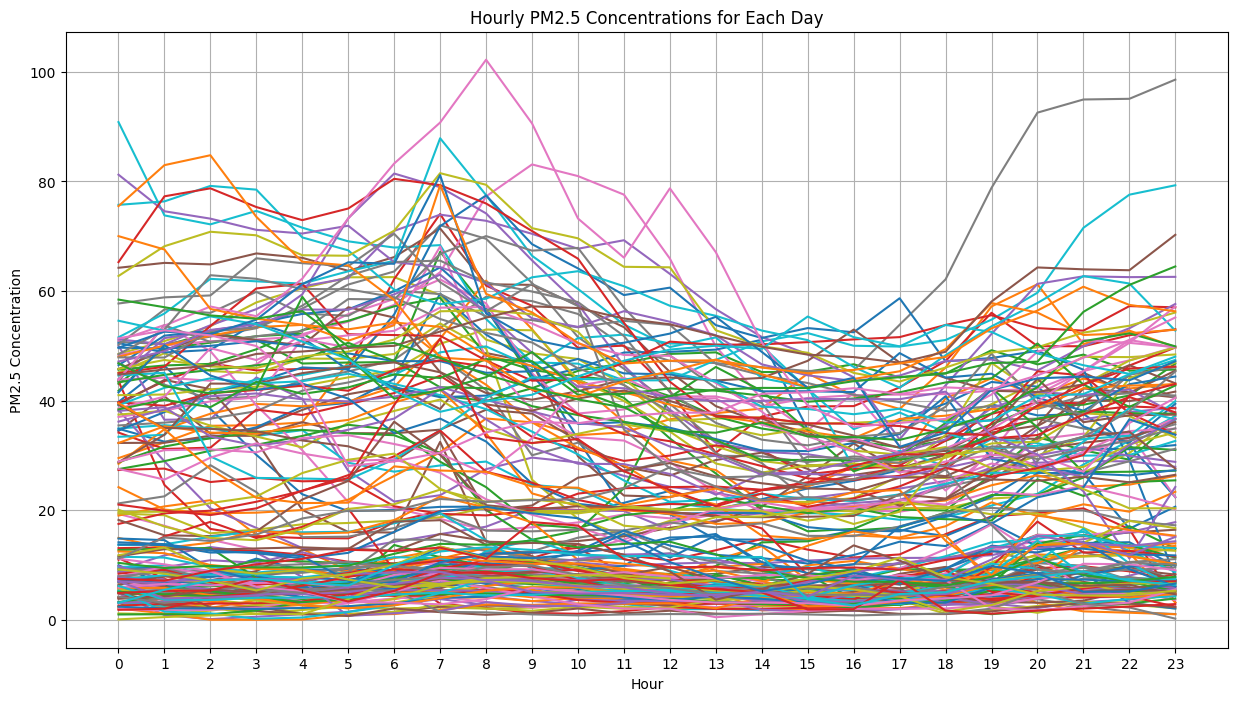

In [5]:
# prompt: plot the each hours of PM2.5 to see the seasonal sequence of each days. no the average. I mean just plot for each hour

import matplotlib.pyplot as plt

# Group data by day and hour
hourly_data = X_train.groupby(['day', 'hour'])['PM2.5'].mean().reset_index()

# Create the plot
plt.figure(figsize=(15, 8))
for day in hourly_data['day'].unique():
    day_data = hourly_data[hourly_data['day'] == day]
    plt.plot(day_data['hour'], day_data['PM2.5'], label=f'Day {day}')

plt.xlabel('Hour')
plt.ylabel('PM2.5 Concentration')
plt.title('Hourly PM2.5 Concentrations for Each Day')
plt.xticks(range(0,24)) # Setting xticks to show all hours
plt.grid(True)
plt.show()

## AutoGluon Time Series Predictor

In [6]:
!pip install autogluon

In [ ]:
# must to restart kernel after pip install autoguon. and run all code again

In [11]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import re

# 1. Load the data
df = pd.read_csv('X_train.csv', names=['time', 'PM2.5'])

# 2. Preprocess the data
def parse_time(time_str):
    match = re.match(r'(\d+) days (\d{2}):', time_str)
    if match:
        days = int(match.group(1))
        hours = int(match.group(2))
        return pd.Timedelta(days=days, hours=hours)
    else:
        return pd.NaT

df['time'] = df['time'].apply(parse_time)
start_date = pd.to_datetime('2023-01-01')  # Adjust start date if needed
df['timestamp'] = start_date + df['time']
df = df.drop('time', axis=1) #drop the old time column.

# Add item_id column
df['item_id'] = 'item_0'  # Add a single item_id for your time series

In [9]:
df = df.iloc[1:]
df.head()

,PM2.5,timestamp,item_id
1,39.75833333333330,2023-01-01 00:00:00,item_0
2,46.34166666666670,2023-01-01 01:00:00,item_0
3,38.483333333333300,2023-01-01 02:00:00,item_0
4,30.1,2023-01-01 03:00:00,item_0
5,22.9,2023-01-01 04:00:00,item_0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4161 entries, 1 to 4161
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PM2.5      4161 non-null   float64       
 1   timestamp  4161 non-null   datetime64[ns]
 2   item_id    4161 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 130.0+ KB


In [13]:
# prompt: check the dtype of PM2.5 column
print(X_train['PM2.5'].dtype)

# Explicitly convert 'PM2.5' to numeric
df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce') # Handle errors by converting them to NaN

# Remove rows with NaN values in 'PM2.5'
df = df.dropna(subset=['PM2.5']) # Drop rows with NaN values in target column

float64


In [17]:
train_data = TimeSeriesDataFrame(df)
train_data

PM2.5
item_id timestamp                     
item_0  2023-01-01 00:00:00  39.758333
        2023-01-01 01:00:00  46.341667
        2023-01-01 02:00:00  38.483333
        2023-01-01 03:00:00  30.100000
        2023-01-01 04:00:00  22.900000
...                                ...
        2023-11-04 15:00:00   9.425000
        2023-11-04 16:00:00   9.541667
        2023-11-04 17:00:00   9.141667
        2023-11-04 18:00:00  10.908333
        2023-11-04 19:00:00  12.025000

[4161 rows x 1 columns]

In [ ]:
# Create a TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(df)

# 3. Train the model
predictor = TimeSeriesPredictor(
    prediction_length=796,  # Calculate prediction length
    path="AutoGluon-TimeSeries-PM25",
    target="PM2.5",
    eval_metric="MSE",
    freq="H"
)

predictor.fit(
    train_data,
    time_limit=300,  # Adjust time limit as needed (seconds)
    presets=["best_quality"]
)

/usr/local/lib/python3.11/dist-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to '/content/AutoGluon-TimeSeries-PM25'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       11.41 GB / 12.67 GB (90.0%)
Disk Space Avail:   74.63 GB / 112.64 GB (66.3%)
Setting presets to: ['best_quality']

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 796,
 'quanti

In [ ]:
train_data

PM2.5
item_id timestamp                     
item_0  2023-01-01 00:00:00  39.758333
        2023-01-01 01:00:00  46.341667
        2023-01-01 02:00:00  38.483333
        2023-01-01 03:00:00  30.100000
        2023-01-01 04:00:00  22.900000
...                                ...
        2023-11-04 15:00:00   9.425000
        2023-11-04 16:00:00   9.541667
        2023-11-04 17:00:00   9.141667
        2023-11-04 18:00:00  10.908333
        2023-11-04 19:00:00  12.025000

[4161 rows x 1 columns]

In [ ]:
# 4. Create future dataframe for prediction
future_index = pd.date_range(
    start=start_date + pd.Timedelta(days=307, hours=20),  # Add 3 hours here
    # periods=340 * 24 + 22 - (307 * 24 + 20),
    periods=796,
    freq="H"
)

<ipython-input-11-8ed49e108430>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(


In [ ]:
future_df = pd.DataFrame({'timestamp': future_index})
future_df['item_id'] = 'item_0' #AutoGluon needs an item_id.
future_data = TimeSeriesDataFrame(future_df)

In [ ]:
# 5. Make predictions
predictions = predictor.predict(train_data) #Remove known_data

# 6. Extract and display predictions
predicted_values = predictions['mean'].values

# Create a dataframe for the predictions
predict_df = pd.DataFrame({'timestamp':future_index, 'PM2.5':predicted_values})

print(predict_df)

data with frequency 'None' has been resampled to frequency 'h'.
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


              timestamp      PM2.5
0   2023-11-04 20:00:00  20.394861
1   2023-11-04 21:00:00  22.604019
2   2023-11-04 22:00:00  21.477989
3   2023-11-04 23:00:00  23.702585
4   2023-11-05 00:00:00   5.479795
..                  ...        ...
791 2023-12-07 19:00:00   7.523377
792 2023-12-07 20:00:00   8.893969
793 2023-12-07 21:00:00  11.691111
794 2023-12-07 22:00:00  11.377798
795 2023-12-07 23:00:00  13.348114

[796 rows x 2 columns]


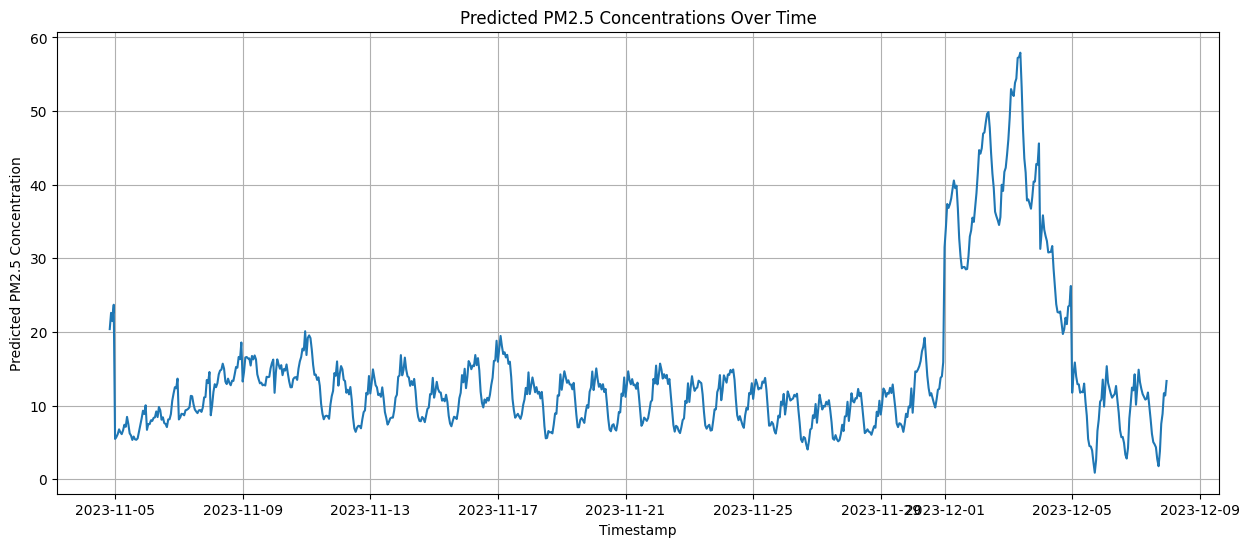

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(predict_df['timestamp'], predict_df['PM2.5'])
plt.xlabel('Timestamp')
plt.ylabel('Predicted PM2.5 Concentration')
plt.title('Predicted PM2.5 Concentrations Over Time')
plt.grid(True)
plt.show()

In [ ]:
predict_df.head()

,timestamp,PM2.5
0,2023-11-04 20:00:00,20.394861
1,2023-11-04 21:00:00,22.604019
2,2023-11-04 22:00:00,21.477989
3,2023-11-04 23:00:00,23.702585
4,2023-11-05 00:00:00,5.479795


In [ ]:
import pandas as pd

predict_df["time(day-hour)"] = predict_df["timestamp"].apply(lambda x: f"{x.dayofyear - 1} days {x.strftime('%H:%M:%S')}")

In [ ]:
predict_df.drop(columns=['timestamp'])

,PM2.5,time(day-hour)
0,20.394861,307 days 20:00:00
1,22.604019,307 days 21:00:00
2,21.477989,307 days 22:00:00
3,23.702585,307 days 23:00:00
4,5.479795,308 days 00:00:00
...,...,...
791,7.523377,340 days 19:00:00
792,8.893969,340 days 20:00:00
793,11.691111,340 days 21:00:00
794,11.377798,340 days 22:00:00


In [ ]:
# Reorder columns using a list of column names
predict_df = predict_df[['time(day-hour)', 'PM2.5']]

In [ ]:
# Save to CSV
predict_df.to_csv('iot_796_submission.csv', index=False)

In [ ]:
import pandas as pd

sample_submission = pd.read_csv('sample_submission.csv')

# Assuming your prediction dataframe is named 'predict_df'
# and it has a 'time(day-hour)' column as in your previous code

# Extract day and hour from 'time(day-hour)' in sample_submission
sample_submission[['day', 'hour']] = sample_submission['time(day-hour)'].str.extract(r'(\d+) days (\d{2}):')
sample_submission['day'] = sample_submission['day'].astype(int)
sample_submission['hour'] = sample_submission['hour'].astype(int)

# Extract day and hour from the 'time(day-hour)' column in predict_df (if it doesn't exist already)
predict_df[['day', 'hour']] = predict_df['time(day-hour)'].str.extract(r'(\d+) days (\d{2}):')
predict_df['day'] = predict_df['day'].astype(int)
predict_df['hour'] = predict_df['hour'].astype(int)


# Merge the DataFrames based on 'day' and 'hour'
merged_df = pd.merge(sample_submission, predict_df, on=['day', 'hour'], how='left')

In [ ]:
merged_df

,time(day-hour)_x,PM2.5_x,day,hour,time(day-hour)_y,PM2.5_y
0,307 days 20:00:00,492.858185,307,20,307 days 20:00:00,20.394861
1,307 days 21:00:00,547.659041,307,21,307 days 21:00:00,22.604019
2,307 days 22:00:00,317.483081,307,22,307 days 22:00:00,21.477989
3,307 days 23:00:00,300.463007,307,23,307 days 23:00:00,23.702585
4,308 days 00:00:00,170.994191,308,0,308 days 00:00:00,5.479795
...,...,...,...,...,...,...
215,340 days 19:00:00,325.376800,340,19,340 days 19:00:00,7.523377
216,340 days 20:00:00,874.423616,340,20,340 days 20:00:00,8.893969
217,340 days 21:00:00,872.135053,340,21,340 days 21:00:00,11.691111
218,340 days 22:00:00,43.822110,340,22,340 days 22:00:00,11.377798


In [ ]:
# Keep only the relevant columns
merged_df = merged_df[['time(day-hour)_x', 'PM2.5_y']]
merged_df.columns = ['time(day-hour)', 'PM2.5_y'] # Rename columns

# Save to CSV
merged_df.to_csv('final_submission.csv', index=False)

KeyError: "['PM2.5'] not in index"

In [ ]:
# final_submission เอาไฟล์นี้ส่ง ลองไปอีกสองรอบดูถ้า public111 private113, ถ้า public113 private120 น่าจะแกว่งๆประมาณนี้

,time(day-hour),PM2.5_y
0,307 days 20:00:00,20.394861
1,307 days 21:00:00,22.604019
2,307 days 22:00:00,21.477989
3,307 days 23:00:00,23.702585
4,308 days 00:00:00,5.479795
...,...,...
215,340 days 19:00:00,7.523377
216,340 days 20:00:00,8.893969
217,340 days 21:00:00,11.691111
218,340 days 22:00:00,11.377798
